<a href="https://colab.research.google.com/github/clarissa-fernanda/Solubiliza-o_metano/blob/main/solubiliza%C3%A7%C3%A3o_metano_em_%C3%A1gua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%bash
!rm -rf dasslcy
!git clone https://github.com/clarissa-fernanda/dasslcy

Cloning into 'dasslcy'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 231 (delta 3), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (231/231), 1.37 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [2]:
# %%bash
!rm -rf dasslc2py
!git clone https://github.com/asanet/dasslc2py

Cloning into 'dasslc2py'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 74 (delta 3), reused 1 (delta 0), pack-reused 63
Receiving objects: 100% (74/74), 408.18 KiB | 3.32 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [3]:
# %%bash
!unzip -o dasslcy/dasslc_v39.zip
!mkdir dasslcy/dasslc_base
!cp dasslc2py/dasslc/dasslc.c dasslcy/dasslc_base/dasslc.c
!cp dasslc2py/dasslc/dasslc.h dasslcy/dasslc_base/dasslc.h

Archive:  dasslcy/dasslc_v39.zip
  inflating: titlepage.sty           
  inflating: dasslc.dll              
  inflating: dasslc.h                
  inflating: dasslc.c                
  inflating: dapert.c                
  inflating: test_pend.m             
  inflating: pend.m                  
  inflating: jacpend.m               
  inflating: dasslc2ml.c             
  inflating: dasslc.pdf              
  inflating: dasslc.tex              
  inflating: parallel.bib            
  inflating: dasslc.m                
  inflating: README.dasslc2ml        
  inflating: dydt1.m                 
  inflating: test1.m                 
  inflating: dydt.m                  
  inflating: test.m                  
  inflating: dademo.c                
  inflating: demo2.c                 
  inflating: dademo2.c               
  inflating: demo_rt.c               
  inflating: pend.c                  
  inflating: demo.c                  
  inflating: license.txt             
  inflating: cabe

In [4]:
%%writefile dasslcy/dasslcy/dasslc.pyx
#cython: boundscheck=False
#cython: wraparound=False

# TODO Accept np.array([1, 0]) with int and convert to float inside solve function
# TODO: Profile

import numpy as np
cimport numpy as np
cimport dasslcy.dasslc_def as dasslc_def

np.import_array()

cdef object pyres
cdef int SHARED_RES_MEM = 0

cdef dasslc_def.BOOL residuals(dasslc_def.PTR_ROOT *root,
                                dasslc_def.REAL t, dasslc_def.REAL *y,
                                dasslc_def.REAL *yp, dasslc_def.REAL *res,
                                dasslc_def.BOOL *jac) noexcept:
    cdef:
        np.npy_intp shape[1]
        int size, j
        cdef int carr[3]
        np.float64_t[:] res_view
        np.ndarray y_np
        np.ndarray yp_np, res_shared
        tuple return_pyres

    size = root.rank
    shape[0] = <np.npy_intp>size
    y_np = np.PyArray_SimpleNewFromData(1, shape, np.NPY_DOUBLE, y)
    yp_np = np.PyArray_SimpleNewFromData(1, shape, np.NPY_DOUBLE, yp) #PyINcre???

    # Check for extra user arguments
    rpar = None if root.user is NULL else <object>root.user

    if SHARED_RES_MEM < 1:
        if rpar is None:
            arglist = (t, y_np, yp_np)
        else:
            arglist = (t, y_np, yp_np, rpar)
    else:
        # &res_view[0] = res
        res_shared = np.PyArray_SimpleNewFromData(1, shape, np.NPY_DOUBLE, res) #PyINcre???
        if rpar is None:
            arglist = (t, y_np, yp_np, res_shared)
        else:
            arglist = (t, y_np, yp_np, rpar, res_shared)

    # Run python function
    return_pyres = pyres(*arglist)

    # Copying data from python to c at &res[0]
    if SHARED_RES_MEM < 1:
        res_view = return_pyres[0]
        for j in range(size):
            res[j] = res_view[j]

    ires = <int> return_pyres[1]
    return ires

def solve(resfun, np.float64_t[:] tspan, np.float64_t[:] y0,
                    np.float64_t[:] yp0 = None, rpar=None, rtol=1e-6,
                    atol=1e-8, index=None, int share_res = 0): #, np.int_t[:] index=None
    global pyres
    global SHARED_RES_MEM

    cdef:
        dasslc_def.PTR_ROOT root
        int neq, ntp, ntp_out
        dasslc_def.REAL t0, *yp_ptr
        dasslc_def.BOOL err
        np.ndarray[np.float64_t, ndim=2] y_sol, yp_sol
        np.float64_t[:] t_sol
        int j, k
        float tf
        np.ndarray[int] index_np
        int *index_ptr
        int index_fake[5]

    pyres = resfun
    neq = y0.size
    ntp = tspan.size

    # Error when using the &index[0] directly, thus creating a helper np.array
    if index is None:
        index_ptr = NULL
    else:
        if isinstance(index, int):
            index_np = np.array([index], dtype=np.intc)
        else:
            index_np = np.empty(index.size, dtype=np.intc)
            for j in range(index.size):
                index_np[j] = index[j]
        index_ptr = <int*>&index_np[0]

    # Set the rpar if any
    if rpar is None:
        root.user = NULL
    else:
        root.user = <void*>rpar

    if yp0 is None:
        yp_ptr = NULL
    else:
        yp_ptr = &yp0[0]

    SHARED_RES_MEM = share_res

    # Setup dasslc:
    t0 = tspan[0] if ntp > 1 else 0.0
    err = dasslc_def.daSetup("?",&root, residuals, neq,
                                t0, &y0[0], yp_ptr, index_ptr, NULL, NULL)
    if err > 0:
        print('Setup error here')

    # Configure root structure
    root.iter.stol = 1
    root.iter.atol[0] = atol
    root.iter.rtol[0] = rtol

    # Define delta t and final time based on tspan input
    ntp_out = ntp if ntp > 2 else 100
    if ntp == 1:
        dt = <double> tspan[0]/(ntp_out-1)
        tf = t0 + dt
    elif ntp == 2:
        dt = <double> (tspan[1]-tspan[0])/(ntp_out-1)
        tf = t0 + dt
    else:
        tf = tspan[1]

    # Find initial derivatives if not given
    if yp0 is None:
        err = dasslc_def.dasslc(dasslc_def.INITIAL_COND, &root,
                                residuals, &t0, tf, NULL, NULL)
        if (err < 0):
            error = "Failed in finding consistent initial condition. Error: {}".format(err)
            dasslc_def.daFree(&root)
            raise TypeError(error)

    # Create and Update solution at t0
    y_sol = np.empty([ntp_out, neq])
    yp_sol = np.empty([ntp_out, neq])
    t_sol = np.empty(ntp_out)
    for j in range(neq):
        y_sol[0, j] = root.y[j]
        yp_sol[0, j] = root.yp[j]

    # Call the dasslc function for all tspan
    for k in range(1, ntp_out):
        tf = tspan[k] if ntp > 2 else t0 + dt
        err = dasslc_def.dasslc(dasslc_def.TRANSIENT, &root, residuals, &t0, tf, NULL, NULL)
        if (err < 0):
            error = "Error during integration: {}".format(err)
            dasslc_def.daFree(&root)
            raise TypeError(error)
        t_sol[k] = root.t
        for j in range(neq):
            y_sol[k, j] = root.y[j]
            yp_sol[k, j] = root.yp[j]

    # Clean Up
    dasslc_def.daFree(&root)

    return (t_sol, y_sol, yp_sol)

Overwriting dasslcy/dasslcy/dasslc.pyx


# test 1 - build_ext

In [5]:
# %%bash
# cd dasslcy
# python setup.py build_ext --inplace

In [6]:
# !ls dasslcy/build/lib.linux-x86_64-cpython-310/dasslcy

In [7]:
# !cp dasslcy/build/lib.linux-x86_64-cpython-310/dasslcy/dasslc.cpython-310-x86_64-linux-gnu.so .
# import dasslc

# example

In [8]:
# import numpy as np
# try:
#     import matplotlib.pyplot as plt
#     has_plt = True
# except ImportError:
#     has_plt = False
# import dasslc

# def model0(t, y, yp):  # --------------- Minimum of 3 input arguments
#     # ------------- Always allocate res as a numpy array, even if it has len = 1.
#     res = np.empty(1)
#     res[0] = yp[0] + 2*y[0]  # ------- Declare the residual
#     ires = 0  # ---------------------- Set ires = 0 if everything is ok
#     # -------------- Beware: ires must always be returned as second output.
#     return res, ires

# ######################################## Solve model0 ##############################################
# print('------- Solve model0  ---------- ')
# # ---------------------- Integration interval with initial and final time
# t0 = np.array([0.0, 1.0])
# y0 = np.array([1.0])  # ---------------------- Initial condition

# t, y, yp = dasslc.solve(model0, t0, y0)  # ---#| The simplest call to dasslc,
# #| with all the mandatory inputs and outputs.
# #| y and yp are equally spaced in all time span
# # Plot results
# np.asarray(t),y

# plt.plot( np.asarray(t),y )

# test 2 - pip install

In [9]:
# exit
#restarts kernel

In [5]:
!ls
# !rm dasslc.cpython-310-x86_64-linux-gnu.so

cabeca.tex     dasslc.c		dasslc.tex     dydt.m	     pend.c		 test_pend.m
dademo1.dat    dasslc.dll	dasslcy        jacpend.m     pend.dat		 testss.dat
dademo2.c      dasslc.h		demo2.c        license.txt   pend.m		 testss.m
dademo2.dat    dasslc.m		demo.c	       lpext.psm     README.dasslc2ml	 titlepage.sty
dademo.c       dasslc.mexw32	demo.dat       lpext.tex     README.dasslc2ml-2
dapert.c       dasslc.mexw64	demo_recall.c  lprep68.pro   sample_data
dasslc2ml.c    dasslc.pdf	demo_rt.c      man12.sty     test1.m
dasslc2mlss.c  dasslcss.mexw32	dydt1.m        manualin.sty  test2.m
dasslc2py      dasslcss.mexw64	dydt2.m        parallel.bib  test.m


In [6]:
%%bash
cd dasslcy
# pip install . -r requirements.txt

pip install -v .
#install without numpy version requirements

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Processing /content/dasslcy
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for dasslcy: filename=dasslcy-0.1-cp310-cp310-linux_x86_64.whl size=566587 sha256=b175167251a4b1e3234b718a41ebce44b4298b0f222b217d62e334bbda9c88c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-qqamr5k3/wheels/79/2f/53/98b2cb35d6ede3587e35e2ede2cb4bdc3f84cf97fdbd9c3bb2
Successfully built dasslcy


  Running command python setup.py egg_info
  /usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dasslcy/dasslcy/dasslc.pyx
    tree = Parsing.p_module(s, pxd, full_module_name)
  Compiling dasslcy/dasslc.pyx because it changed.
  [1/1] Cythonizing dasslcy/dasslc.pyx
  running egg_info
  creating /tmp/pip-pip-egg-info-f3xbsl5y/dasslcy.egg-info
  writing /tmp/pip-pip-egg-info-f3xbsl5y/dasslcy.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-f3xbsl5y/dasslcy.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-f3xbsl5y/dasslcy.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-f3xbsl5y/dasslcy.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-f3xbsl5y/dasslcy.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-f3xbsl5y/dasslcy.eg

In [7]:
import dasslcy

In [13]:
!7z a dasslc2py.zip dasslc2py


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Open archive: dasslc2py.zip
--
Path = dasslc2py.zip
Type = zip
Physical Size = 848305

Scanning the drive:
  0M Scan           24 folders, 63 files, 1483496 bytes (1449 KiB)

Updating archive: dasslc2py.zip

Items to compress: 87

  0%    
Files read from disk: 63
Archive size: 848306 bytes (829 KiB)
Everything is Ok


In [14]:
!7z a dasslcy.zip dasslcy


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Open archive: dasslcy.zip
--
Path = dasslcy.zip
Type = zip
Physical Size = 3575596

Scanning the drive:
  0M Scan           31 folders, 64 files, 7316395 bytes (7145 KiB)

Updating archive: dasslcy.zip

Items to compress: 95

  0%     25% 35 U dasslcy/build/temp.linux-x86_64-cpython-310/dasslc_base/dasslc.o                                                                           40% 36 U dasslcy/build/temp.linux-x86_64-cpython-310/dasslcy/dasslc.o                                                                      

In [8]:
import numpy as np

def PR(Tp, P, x, Acentric, Tc, Pc, root):
    NC = len(x)
    a = np.zeros(NC)
    b = np.zeros(NC)
    ac = np.zeros(NC)
    bmix = 0.0
    amix = 0.0

    # Cálculo dos parâmetros a (energético) e b (volumétrico) por componente
    for i in range(NC):
        m = 0.37464 + (1.54226 - 0.26992*Acentric[i])*Acentric[i]
        alfa = (1.0 + m*(1.0 - np.sqrt(Tp/Tc[i])))**2
        ac[i] = 0.45724*Tc[i]**2/Pc[i]
        a[i] = ac[i]*alfa

    for i in range(NC):
        b[i] = 0.07780*Tc[i]/Pc[i]

    # Normalizing mole fractions
    norm = np.sum(x)
    xAux = x / norm

    # Parâmetros de interação binária kij
    BinIntCoef = np.zeros((NC, NC))

    # Cálculo dos parâmetros a (energético) e b (volumétrico) para a mistura
    for i in range(NC):
        for j in range(NC):
            amix += xAux[i]*xAux[j]*np.sqrt(a[i]*a[j])*(1.0 - BinIntCoef[i,j])

    for i in range(NC):
        bmix += xAux[i]*b[i]

    Samix = np.zeros(NC)
    for index in range(NC):
        for i in range(NC):
            Samix[index] += 2.0*xAux[i]*np.sqrt(a[index]*a[i])*(1.0 - BinIntCoef[index,i])

    # Calculo do volume molar da fase root
    sigma_eos = 1.0 + np.sqrt(2.0)
    epsilon_eos = 1.0 - np.sqrt(2.0)

    aux = P / (8.3144621*Tp)

    coefCubic = np.zeros(4)
    coefCubic[0] = 1.0
    coefCubic[1] = (sigma_eos + epsilon_eos - 1)*bmix - 1/aux
    coefCubic[2] = sigma_eos*epsilon_eos*bmix**2 - (1/aux + bmix)*(sigma_eos + epsilon_eos)*bmix + amix/P
    coefCubic[3] = -(1/aux + bmix)*sigma_eos*epsilon_eos*bmix**2 - bmix*amix/P

    roots = np.roots(coefCubic)
    V = roots[roots > 0.0]

    if len(V) == 1:
        Vol = V[0]
    elif len(V) == 2:
        if root == 1:
            Vol = min(V)
        elif root == 0:
            Vol = max(V)
    elif len(V) == 3:
        if root == 1:
            Vol = min(V)
        elif root == 0:
            Vol = max(V)

    # Calculo do coeficiente de fugacidade do componente index
    Z = Vol*aux
    FugCoef = np.zeros(NC)
    for index in range(NC):
        FugCoef[index] = np.exp((b[index]/bmix)*(Z-1.0)-np.log((Vol-bmix)*aux)-amix/(bmix*8.3144621*Tp*(epsilon_eos-sigma_eos))*(Samix[index]/amix-b[index]/bmix)*np.log((Vol+epsilon_eos*bmix)/(Vol+sigma_eos*bmix)))

    return Vol, FugCoef


In [9]:
import numpy as np

# Função para calcular coeficientes de atividade usando modelo NRTL
def Gamma(T, x, alpha, A, B):
    # Inicializar arrays para tau, G e gamma
    A = np.array(A)
    B = np.array(B)
    tau = np.zeros([2, 2])
    for j in range(2):
        for i in range(2):
            tau[j, i] = A[j, i] + (B[j,i]*((330.15 / T) - 1.0))

    G = np.zeros([2, 2])
    for j in range(2):
        for i in range(2):
            G[j, i] = np.exp((-alpha[j, i] * tau[j, i]))

    Gamma = np.zeros([2])
    for i in range(2):
        Sj1 = 0
        Sj2 = 0
        Sj3 = 0
        for j in range(2):
            Sj1 += tau[j, i] * G[j, i] * x[j]
            Sj2 += G[j, i] * x[j]

            Sk1 = 0
            Sk2 = 0
            Sk3 = 0
            for k in range(2):
                Sk1 += G[k, j] * x[k]
                Sk2 += x[k] * tau[k, j] * G[k, j]
                Sk3 += G[k, j] * x[k]

            Sj3 += ((x[j] * G[i, j]) / Sk1) * (tau[i, j] - (Sk2 / Sk3))

        Gamma[i] = np.exp(Sj1 / Sj2 + Sj3)

    return Gamma

In [10]:
def liquid_density_rackett(TT, P, x, Acentric, Tc, Pc, Vc):
    R = 8.3144621  # Constante universal dos gases [m³ Pa / mol K = J/ mol K]
    NC = len(x)

    # Temperatura Reduzida da Mistura
    KK = []
    for i in range(NC):
        row = []
        for j in range(NC):
            kij = 1.0 - (8.0 * (Vc[i]*Vc[j])**(1.0/2.0)) / ((Vc[i]**(1.0/3.0) + Vc[j]**(1.0/3.0))**(3.0))
            row.append(kij)
        KK.append(row)

    Tcc = []
    for i in range(NC):
        row = []
        for j in range(NC):
            tcc_ij = (1.0 - KK[i][j]) * ((Tc[i]*Tc[j])**(1.0/2.0))
            row.append(tcc_ij)
        Tcc.append(row)

    # Parâmetro Fi
    SumFi = sum(x[i]*Vc[i] for i in range(NC))
    Fi = [(x[i]*Vc[i]) / SumFi for i in range(NC)]

    Tcm = 0.0
    for i in range(NC):
        for j in range(NC):
            Tcm += Fi[i]*Fi[j]*Tcc[i][j]

    # Temperatura Reduzida
    Trm = TT / Tcm

    # Volume molar da mistura
    ZRA = [0.29056 - (0.08775 * Acentric[i]) for i in range(NC)]

    ZRAm = 0.0
    for i in range(NC):
        ZRAm += x[i]*ZRA[i]

    SumTc = 0.0
    for i in range(NC):
        SumTc += x[i]*Tc[i]/(Pc[i])

    Vm = R * SumTc * (ZRAm**(1.0 + (((1.0 - Trm))**(2.0/7.0))))

    return Vm


[0.99315066 1.00599325]
0.00032091399674096286
nsol 6.271878826725801e-07
------- Solve model5  ---------- 
[[5.00000000e+00 1.00000000e-04 5.00010000e+00 4.36049467e+00
  1.00656226e-04 4.96750196e+04 1.39934377e-03 3.11609967e+03
  7.17189801e+06]
 [5.00000000e+00 1.06049393e-04 5.00010605e+00 4.36048847e+00
  1.00656472e-04 4.96749583e+04 1.39934353e-03 3.11609578e+03
  7.17188900e+06]
 [5.00000000e+00 1.11759534e-04 5.00011176e+00 4.36048210e+00
  1.00656704e-04 4.96749004e+04 1.39934330e-03 3.11609175e+03
  7.17187967e+06]
 [5.00000000e+00 1.17154509e-04 5.00011715e+00 4.36047609e+00
  1.00656924e-04 4.96748457e+04 1.39934308e-03 3.11608794e+03
  7.17187085e+06]
 [5.00000000e+00 1.22234523e-04 5.00012223e+00 4.36047043e+00
  1.00657130e-04 4.96747942e+04 1.39934287e-03 3.11608436e+03
  7.17186254e+06]
 [5.00000000e+00 1.27015842e-04 5.00012702e+00 4.36046510e+00
  1.00657325e-04 4.96747458e+04 1.39934268e-03 3.11608098e+03
  7.17185472e+06]
 [5.00000000e+00 1.31515644e-04 5.000131

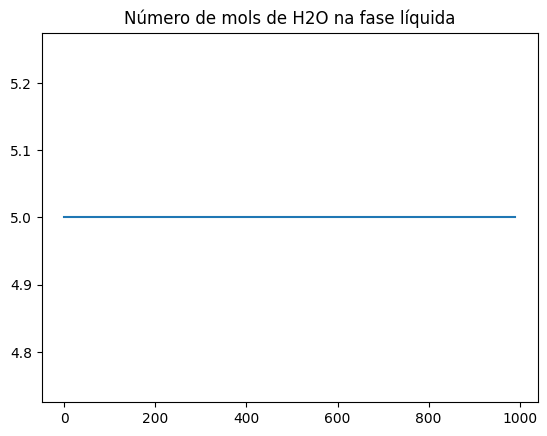

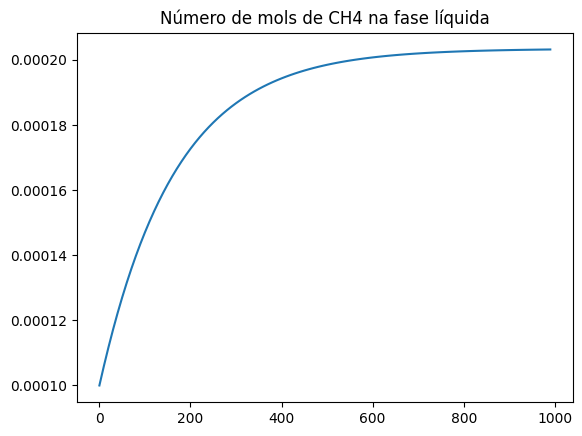

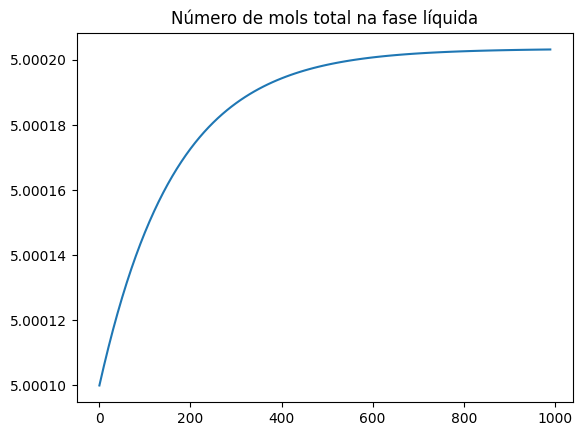

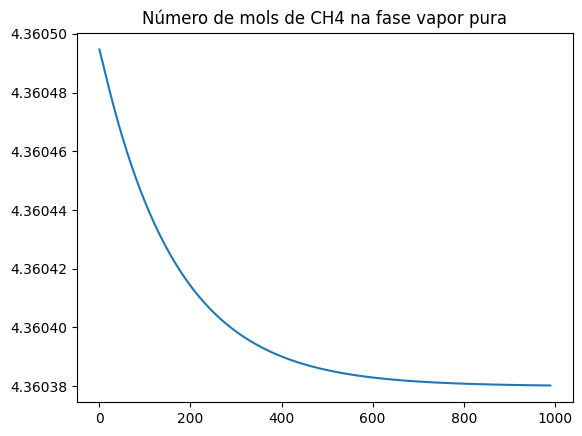

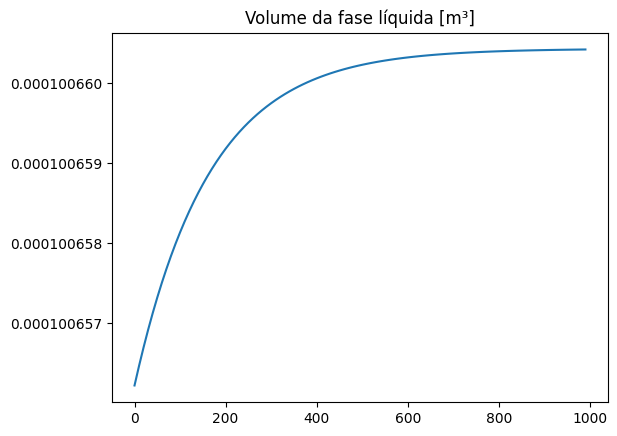

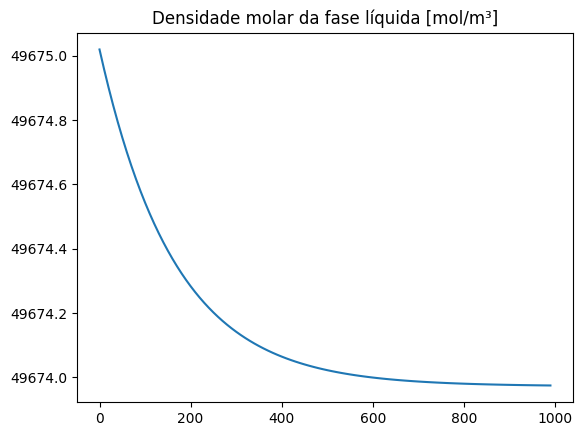

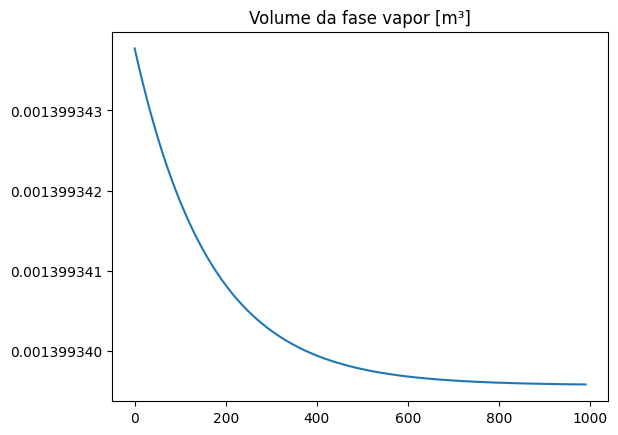

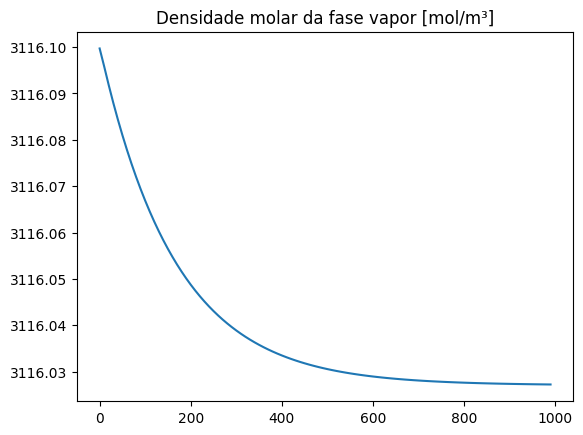

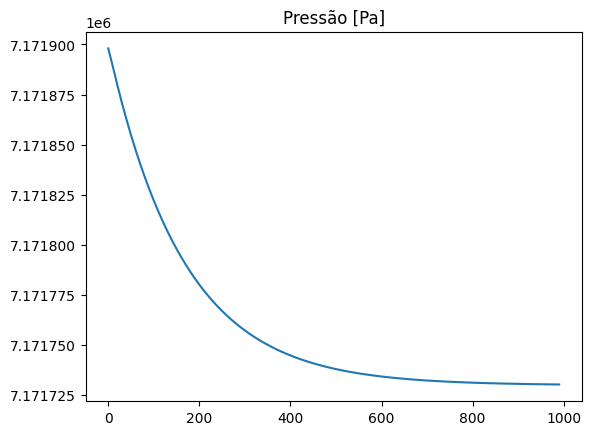

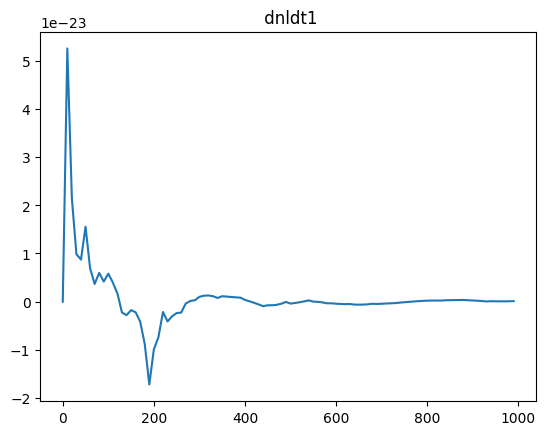

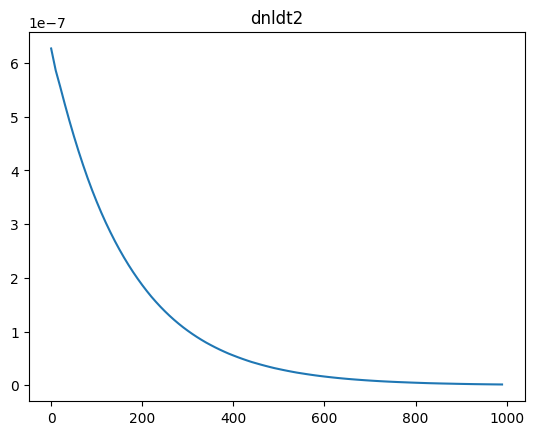

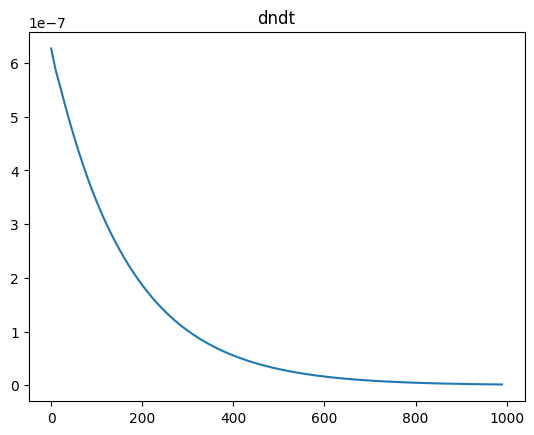

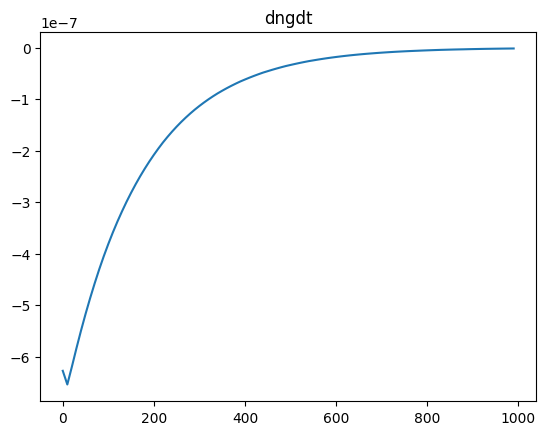

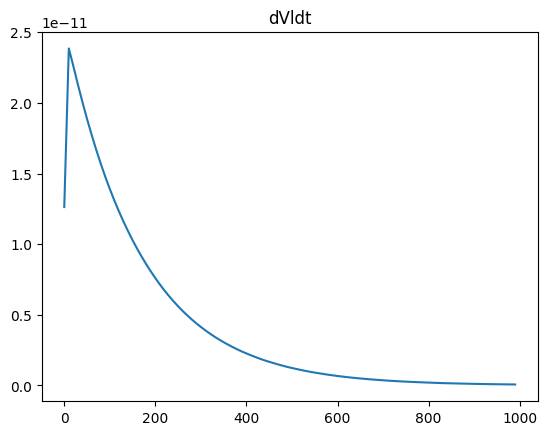

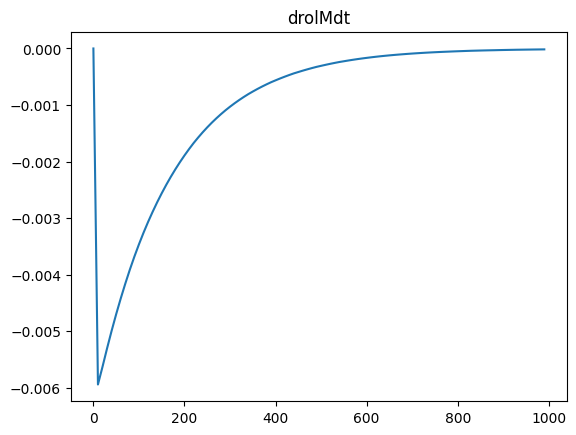

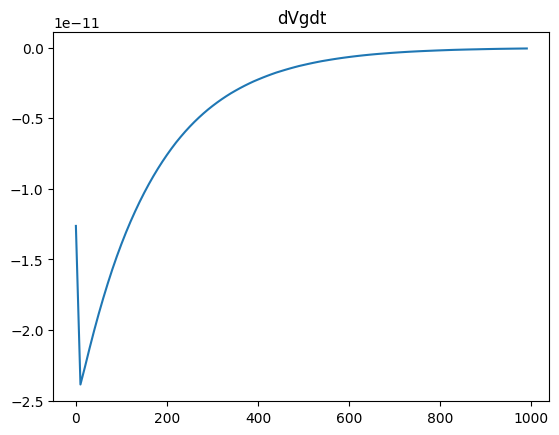

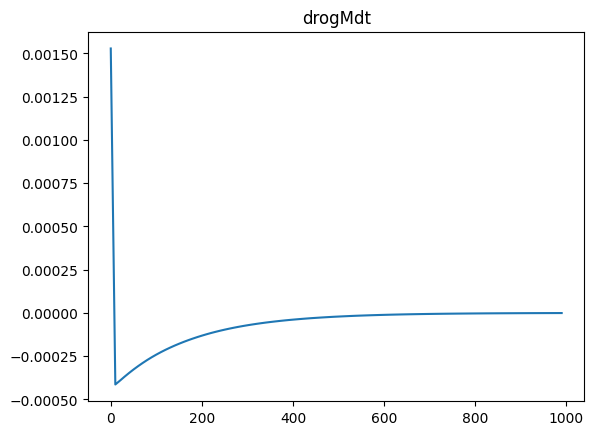

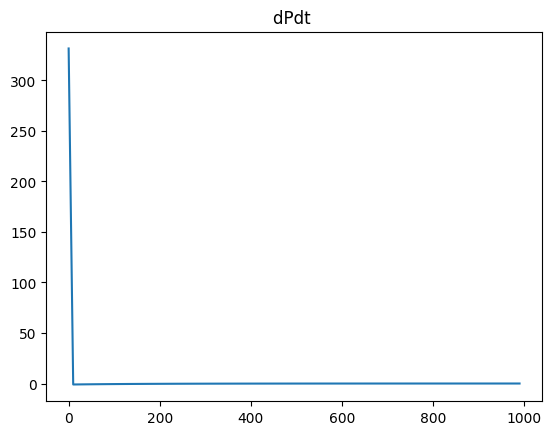

In [11]:
#Calculo da solubilização de CH4 em H2O

#!nl - número de mols do componente NC na fase líquida [mol]
#n - número de mols da fase líquida [mol]
#ng - número de mols de metano na fase vapor [mol] (Fase vapor considerada pura)
#Vl - volume da fase líquida [m³]
#Vg - volume da fase vapor [m³]
#roLM - densidade molar da fase líquida [mol/m³]
#rogM - densidade molar da fase vapor [mol/m³]
#P - Pressão dos sitema [Pa}

import numpy as np
import matplotlib.pyplot as plt
import math


# Atribuindo valores dos dados de entrada do problema
# H2O - (NC =1, index = 1), CH4 - (NC = 2, index = 2)
# Fase vapor - root = 0
# Fase líquida - root = 1

Tp = 275.15  # Temperatura do sistema [K]
# Massa molar do componente NC [g/mol]
MM = {
    0: 18.015,  # H2O
    1: 16.043   # CH4
}
R = 8.3144621  # Constante universal dos gases [m³ Pa / mol K = J/ mol K]
pi = 4 * np.arctan(1.0)  # pi [rad]
ro = {
    0: 997.0,  # Densidade da água [g/m³]
    1: 0.656   # Densidade do CH4 [g/m³]
}
vis = {
    0: (1.0 / MM[0]) * np.exp(-3.7188 + (578.918 / (Tp - 137.546))),  # Viscosidade da H2O [mol/ m s]
    1: (1.0 / MM[1]) * np.exp(-25.5947 + (25392 / (Tp + 969.306)))    # Viscosidade da CH4 [mol/ m s]
}
Vr = 1.5e-3  # Volume do reator [m³]
Rin = 0.054  # Raio interno do reator [m]
D = 0.0347e-4  # Difusividade do metano em água [m²/s]
Dag = 0.036  # Diâmetro do agitador [m]
s = 300.0  # Taxa de agitação [rps]
Npo = 2.43  # Número de potência do agitador
# Temperatura crítica do componente NC [K]
Tc = {
    0: 647.14,  # H2O
    1: 190.56   # CH4
}
# Pressão crítica do componente NC [Pa]
Pc = {
    0: 22064000.0,  # H2O
    1: 4599000.0    # CH4
}
# Fator acentrico do componente NC
Acentric = {
    0: 0.344,  # H2O
    1: 0.008   # CH4
}
# Vc(NC) - Volume crítico do componente NC [cm³/mol]
Vc = {
    0: 55.95e-6,  # H2O
    1: 98.60e-6   # CH4
}
# Parâmetros da correlação da constante de Henry a diluição infinita para chute inicial da composição de equilíbrio do metano na interface G-L
v0 = 32e-12  # [m³/mol]
B = {
    0: 15.826277,  # Adimensional
    1: -1559.063   # B
}
# Parâmetros da correlação da fugacidade da fase líquida hipotética do CH4
v2 = 5.2e-5  # [m³/mol]
C = {
    0: 44.4895,
    1: -1.4457,
    2: -2.6880
}
# Parâmetros NRTL
# Linear
Aij = np.array([
    [0.0, -208.76],  # H2O/H2O, H2O/CH4
    [879.302, 0.0]   # CH4/H20, CH4/CH4
])
# Não Linear
Bij = np.array([
    [0.0, -41.8913],   # H2O/H2O, H2O/CH4
    [-430.631, 0.0]   # CH4/H2O, CH4/CH4
])
# Fator de não aleatoriedade
ALPHA = 0.00160748

# Condições iniciais das variáveis (C.I.)
nl = {
    0: 5.0,   # Nº de mols inicial de H2O na fase líquida [mol]
    1: 0.0001    # Nº de mols inicial de CH4 na fase líquida [mol]
}
P = 7171898.0083  # Pressão inicial do sistema [Pa]

#condições iniciais calculadas
# FASE LÍQUIDA
NC=2
# Número de mols da fase líquida [mol]
n = 0.0  # Inicializando o nº de mols da fase líquida
for i in range(NC):
    n += nl[i]
# Fração molar do componente i na fase líquida
xl = [0.0] * NC
for i in range(NC):
    xl[i] = nl[i] / n

# Verificar se a soma das frações molares é 1
xx = 0.0  # Inicializando a soma das frações
for i in range(NC):
    xx += xl[i]
if xx != 1.0:
    print('Soma das frações molares da fase líquida diferente de 1 - VERIFICAR')
    # input()  # Para pausar a execução no Python
#print(xl)
Vm = liquid_density_rackett(Tp, P, xl, Acentric, Tc, Pc, Vc)
VLM = Vm
roLM = 1/VLM
Vl = n/roLM
#print('ROLM', roLM)
root=0.0
xg = [0.0, 0.0]  # Fração molar da fase vapor [mol] - H2O, CH4
xg[1] = 1.0 - xg[0]  # CH4

# Propriedades volumétricas da fase vapor
Vg = Vr - Vl  # Volume da fase vapor [m³]

# Cálculos com o modelo Peng-Robinson (PR)
root = 0.0 # Vapor
Vol, FugCoef = PR(Tp, P, xg, Acentric, Tc, Pc, root)  # Substitua pela função de cálculo em Python
print(FugCoef)
FIV1=FugCoef[1]
# Volume molar da fase vapor [m³/mol]
VgM = Vol
print(VgM)
rogM = 1.0 / VgM  # Densidade molar da fase vapor [mol/m³]
ng = rogM*Vg
alpha = np.zeros([3, 3])  # Array de 3x3 para Alpha
alpha[0, 1] = 0.00160748  # Valor de Alpha para componentes 0 e 1
alpha[1, 0] = alpha[0, 1]  # Mesmo valor para simetria

# Chute inicial
xeq = np.zeros(2)
xeq[1] = (FugCoef[1] * P) / ((np.exp(B[0] + (B[1] / Tp)) * 101325) * np.exp((P* v2) / (R * Tp)))  # CH4
xeq[0] = 1.0 - xeq[1]  # H2O

# Redefinindo variável
xeq0 = xeq[1]  # Chute inicial
tt = 1.0

while tt >= 1.0e-8:
    xeq1 = np.zeros(2)
    xeq1[1] = xeq0  # CH4
    xeq1[0] = 1.0 - xeq[1]  # H2O

    # Cálculo do coeficiente de fugacidade na fase líquida hipotética de CH4 puro
    FiL0 = (Pc[1] * (C[0] / (Tp / Tc[1])) * np.exp((C[1] / (Tp / Tc[1])) + (C[2] / (Tp / Tc[1])) ** 2) *
            np.exp(v2 * (P - 1.013e-5) / (R * Tp))) / P

    # Cálculo da composição de metano no equilíbrio da interface G-L
    IND = np.array([0, 1])  # H2O, CH4
    gamma = Gamma(Tp, xeq1, alpha,  Aij, Bij)
    #print(gamma)
    xeq0 = FugCoef[1] / (gamma[1] * FiL0)  # Fase gasosa metano puro xg(2) = 1.d0 fVCH4 = fLCH4
    tt = abs(xeq1[1] - xeq0)

# Atualizando composição de equilíbrio G-L
xeq[1] = xeq0  # CH4
xeq[0] = 1.0 - xeq[1]  # H2O

# número de mols de CH4 no equilíbrio G-L
neq = xeq[1] * n  # neq = xeq(2)*n

#parametros calculados
# Propriedades do sistema
H = Vr / (np.pi * Rin * Rin)  # Altura do reator [m]
Hl = Vl / (np.pi * Rin * Rin)  # Altura da coluna de líquido [m]

# Propriedades da suspensão
dsus = 1e-3 * ((2.848 * (roLM - rogM) * (roLM - rogM)) - (8.056 * (roLM - rogM)) + ((8.53 * (roLM - rogM)) / ((Tp / Tc[1]) ** 0.3125))) ** 4.0  # Energia específica superficial da suspensão [J/m²]
rosusM = roLM  # rosusM - Densidade molar da suspensão [mol/m³]

# Inicialização da visusM
visusM = 0.0

# Cálculo da viscosidade molar média da suspensão
for i in range(NC):
    visusM += xl[i] * vis[i]

# Massa molar da suspensão [g/mol]
MMsus = 0.0

# Cálculo da massa molar da suspensão
for i in range(NC):
    MMsus += nl[i] * MM[i] / n

# Parâmetros adimensionais do sistema
Re = ((Dag) ** 2) * rosusM * s / visusM  # Reynolds
We = ((Dag) ** 3) * rosusM * s * s / dsus  # Weber
Eu = P / (((Dag) ** 2) * ((rosusM * MMsus) * (s ** 2)))  # Euler

# Área interfacial G-L
Aint = ((1.0 / H) + ((1.0 / Hl) * ((Re ** 1.75) * (We ** 3.0) / (Eu ** 3.0)) * ((rosusM / rogM) ** -2.67))) * Vr  # [m²]

# COEFICIENTE DE DIFUSÃO MÁSSICA DE METANO NA INTERFACE G-L
kd = 0.5 * D * ((Npo * (s ** 3.0) * ((Dag) ** 5.0)) / (visusM / rosusM)) ** (1.0 / 4.0)  # [m/s]
nsol = (Aint*kd/Vl)*(neq-nl[1])
print('nsol', nsol)
ne = 0.0
dnldt1 = 0.0
dnldt2 = nsol
dndt = dnldt2
dngdt = ne - nsol

# Derivadas temporais das densidades molares e dos volumes das fases
droLMdt = 0.0
dVldt = dndt * (1.0 / roLM) + n * droLMdt * (1.0 / (roLM * roLM))
dVgdt = -dVldt
drogMdt = 1.0 / (R * Tp * 0.286)  # drogdt = (1 / R T Zc)

# Derivadas temporais da pressão
dPdt = (R * Tp / Vg) * (neq - nsol - ((P * dVgdt) / (R * Tp)))

#iniciando a dassl
def model15(t, y, yp):

    res = np.empty(9)

    Tp = 275.15  # Temperatura do sistema [K]
    # Massa molar do componente NC [g/mol]
    MM = {
        0: 18.015,  # H2O
        1: 16.043   # CH4
    }
    R = 8.3144621  # Constante universal dos gases [m³ Pa / mol K = J/ mol K]
    pi = 4 * np.arctan(1.0)  # pi [rad]
    ro = {
        0: 997.0,  # Densidade da água [g/m³]
        1: 0.656   # Densidade do CH4 [g/m³]
    }
    vis = {
        0: (1.0 / MM[0]) * np.exp(-3.7188 + (578.918 / (Tp - 137.546))),  # Viscosidade da H2O [mol/ m s]
        1: (1.0 / MM[1]) * np.exp(-25.5947 + (25392 / (Tp + 969.306)))    # Viscosidade da CH4 [mol/ m s]
    }
    Vr = 1.5e-3  # Volume do reator [m³]
    Rin = 0.054  # Raio interno do reator [m]
    D = 0.0347e-4  # Difusividade do metano em água [m²/s]
    Dag = 0.036  # Diâmetro do agitador [m]
    s = 300.0  # Taxa de agitação [rps]
    Npo = 2.43  # Número de potência do agitador
    # Temperatura crítica do componente NC [K]
    Tc = {
        0: 647.14,  # H2O
        1: 190.56   # CH4
    }
    # Pressão crítica do componente NC [Pa]
    Pc = {
        0: 22064000.0,  # H2O
        1: 4599000.0    # CH4
    }
    # Fator acentrico do componente NC
    Acentric = {
        0: 0.344,  # H2O
        1: 0.008   # CH4
    }
    # Vc(NC) - Volume crítico do componente NC [cm³/mol]
    Vc = {
        0: 55.95e-6,  # H2O
        1: 98.60e-6   # CH4
    }
    # Parâmetros da correlação da constante de Henry a diluição infinita para chute inicial da composição de equilíbrio do metano na interface G-L
    v0 = 32e-12  # [m³/mol]
    B = {
        0: 15.826277,  # Adimensional
        1: -1559.063   # B
    }
    # Parâmetros da correlação da fugacidade da fase líquida hipotética do CH4
    v2 = 5.2e-5  # [m³/mol]
    C = {
        0: 44.4895,
        1: -1.4457,
        2: -2.6880
    }
    # Parâmetros NRTL
    # Linear
    Aij = np.array([
        [0.0, -208.76],  # H2O/H2O, H2O/CH4
        [879.302, 0.0]   # CH4/H20, CH4/CH4
    ])
    # Não Linear
    Bij = np.array([
        [0.0, -41.8913],   # H2O/H2O, H2O/CH4
        [-430.631, 0.0]   # CH4/H2O, CH4/CH4
    ])
    # Fator de não aleatoriedade
    ALPHA = 0.00160748

    nl[0] = y[0]   # Número de mols de H2O na fase líquida
    nl[1] = y[1]   # Número de mols de CH4 na fase líquida
    n = y[2]     # Número de mols da fase líquida
    ng = y[3]    # Número de mols de CH4 na fase vapor pura
    Vl = y[4]    # Volume da fase líquida [m³]
    roLM = y[5]  # Densidade molar da fase líquida [mol/m³]
    Vg = y[6]    # Volume da fase vapor [m³]
    rogM = y[7]  # Densidade molar da fase vapor [mol/m³]
    P = y[8]     # Pressão [Pa]

    dnldt1  = yp[0]      # Derivada do volume da fase líquida [m³/s]
    dnldt2 = yp[1]    # Derivada da densidade molar da fase líquida [mol/m³/s]
    dndt = yp[2]       # Derivada do número de mols da fase líquida
    dngdt = yp[3]  # Derivada do número de mols de CH4 na fase líquida
    dVldt = yp[4]  #derivada volume fase liquida
    drolMdt =yp[5]   # Derivada da desidade molar da fase liquida
    dVgdt = yp[6]       # Derivada do volume fase vapor
    drogMdt = yp[7]   # Derivada da densidade molar da fase vapor [mol/m³/s]
    dPdt = yp[8]     # Derivada da pressão

    NC=2
# Fração molar do componente i na fase líquida
    xl = [0.0] * NC
    for i in range(NC):
      xl[i] = y[i] / y[2]
    Vm = liquid_density_rackett(Tp, y[8], xl, Acentric, Tc, Pc, Vc)
    #print(xl)
    VLM = Vm
    #print(xl)
    #print('VLM', VLM)
    res[0] = y[5] - 1/VLM
    res[1] = y[4] - y[2]/y[5]

    #fase vapor
    xg = [0.0, 0.0]  # Fração molar da fase vapor [mol] - H2O, CH4
    xg[1] = 1.0 - xg[0]  # CH4
    res[2] = y[6] - (Vr - y[4])
    # Propriedades volumétricas da fase vapor

    # Cálculos com o modelo Peng-Robinson (PR)
    root = 0.0 # Vapor
    Vol, FugCoef = PR(Tp, y[8], xg, Acentric, Tc, Pc, root)  # Substitua pela função de cálculo em Python
    FIV1=FugCoef[1]
    # Volume molar da fase vapor [m³/mol]
    VgM = Vol
    res[3] = y[7] - 1/VgM
    res[4] = y[3] - y[7] * y[6]

    #Chute inicial
    xeq[1] = (FugCoef[1] * y[8]) / ((math.exp(B[0] + (B[1] / Tp)) * 101325.00) * math.exp(( y[8]* v0) / (R * Tp)))  # CH4
    xeq[0] = 1.0 - xeq[1]  # H2O

# Redefinindo variável
    xeq0 = xeq[1]  # Chute inicial
    tt = 1.0
    while tt >= 1.0e-8:
      xeq1 = np.zeros(2)
      xeq1[1] = xeq0  # CH4
      xeq1[0] = 1.0 - xeq[1]  # H2O
   # Cálculo do coeficiente de fugacidade na fase líquida hipotética de CH4 puro
      FiL0 = (Pc[1] * (C[0] / (Tp / Tc[1])) * math.exp((C[1] / (Tp / Tc[1])) + (C[2] / (Tp / Tc[1]))**2.00) * math.exp(v2 * (y[8] - 1.013e-5) / (R * Tp))) / y[8]

    # Cálculo da composição de metano no equilíbrio da interface G-L
      IND = [0, 1]  # H2O, CH4/
      gamma = Gamma(Tp, xeq1, alpha, Aij, Bij)
      #print(gamma)
      xeq0 = FugCoef[1]/ (gamma[1] * FiL0)  # Fase gasosa metano puro
      tt = abs(xeq1[1] - xeq0)
        #print('aqui', xeq1, xeq2)

    #print("Convergência alcançada.")
    #print("Coeficiente de atividade das espécies:", GAMA_1, GAMA_2)

  # Atualizando composição de equilíbrio G-L

    xeq[1] = xeq0  # CH4
    xeq[0] = 1.0 - xeq[1]  # H2O
    #print(xeq1)
    neq = xeq[1] * y[2]  # neq = xeq(2)*n
# Número de mols de CH4 no equilíbrio G-L
    #parametros calculados
    # Propriedades do sistema
    H = Vr / (np.pi * Rin * Rin)  # Altura do reator [m]
    Hl = y[4] / (np.pi * Rin * Rin)  # Altura da coluna de líquido [m]

    # Propriedades da suspensão
    dsus = 1e-3 * ((2.848 * (y[5] - y[7]) * (y[5] - y[7])) - (8.056 * (y[5] - y[7])) + ((8.53 * (y[5] - y[7])) / ((Tp / Tc[1]) ** 0.3125))) ** 4.0  # Energia específica superficial da suspensão [J/m²]
    rosusM = y[5]  # rosusM - Densidade molar da suspensão [mol/m³]

    # Inicialização da visusM
    visusM = 0.0

#  Cálculo da viscosidade molar média da suspensão
    for i in range(NC):
      visusM += xl[i] * vis[i]

    # Massa molar da suspensão [g/mol]
    MMsus = 0.0

    # Cálculo da massa molar da suspensão
    for i in range(NC):
      MMsus += y[i] * MM[i] / y[2]

    # Parâmetros adimensionais do sistema
    Re = ((Dag) ** 2) * rosusM * s / visusM  # Reynolds
    We = ((Dag) ** 3) * rosusM * s * s / dsus  # Weber
    Eu = y[8] / (((Dag) ** 2) * ((rosusM * MMsus) * (s ** 2)))  # Euler

    # Área interfacial G-L
    Aint = ((1.0 / H) + ((1.0 / Hl) * ((Re ** 1.75) * (We ** 3.0) / (Eu ** 3.0)) * ((rosusM / y[7]) ** -2.67))) * Vr  # [m²]
    # print(Aint)

    # COEFICIENTE DE DIFUSÃO MÁSSICA DE METANO NA INTERFACE G-L
    kd = 0.5 * D * ((Npo * (s ** 3.0) * ((Dag) ** 5.0)) / (visusM / rosusM)) ** (1.0 / 4.0)  # [m/s]
    nsol = (Aint*kd/y[4])*(neq -y[1])
    #print(nsol)
    ne = 0.0
    res[5] = yp[0] - 0
    res[6] = yp[1] - nsol
    res[7] = y[2] - (y[0] + y[1]) #n=nl1+nl2
    res[8]= yp[8]- ((R*Tp/y[6])*(ne-nsol)-(y[8]*yp[6]/(R*Tp)))

    #print(nsol)
    ires = 0
    return res, ires

######################################### Solve model2 #############################################
print('------- Solve model5  ---------- ')
# ------------#| You can also specify only the final time.
t0 = np.arange(0, 1000.0, 10)
#| In this case y and yp are equally spaced in [0 t0]
y0 = np.array([nl[0], nl[1], n,ng,Vl,roLM,Vg,rogM, P])
yp0 = np.array([dnldt1, nsol ,dnldt2,dngdt,dVldt, droLMdt,dVgdt,drogMdt,dPdt]) # ----------------------#| If you are not passing an optional input
#| but is passing the next one, define it as None
atol = 1e-8  # ----------------------- The absolute tolerance
rtol = 1e-6  # ----------------------- The relative tolerance

# Call with optional arguments (yp0 = None)
t, y, yp = dasslcy.solve(model15, t0, y0, yp0)
print(y)
#print(y)
titles = [
    'Número de mols de H2O na fase líquida',
    'Número de mols de CH4 na fase líquida',
    'Número de mols total na fase líquida',
    'Número de mols de CH4 na fase vapor pura',
    'Volume da fase líquida [m³]',
    'Densidade molar da fase líquida [mol/m³]',
    'Volume da fase vapor [m³]',
    'Densidade molar da fase vapor [mol/m³]',
    'Pressão [Pa]'
]

for i, title in enumerate(titles):
    plt.figure()
    plt.plot(np.asarray(t), y[:, i])
    plt.title(title)
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False) # Prevents y-axis values from being rounded
    plt.show()

titles2 = [
    " dnldt1" ,
    "dnldt2",
    "dndt" ,
    "dngdt" ,
    "dVldt" ,
    "drolMdt",
    "dVgdt" ,
    "drogMdt",
    "dPdt ",
]
for i, title in enumerate(titles2):
    plt.figure()
    plt.plot(np.asarray(t), yp[:, i])
    plt.title(title)
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False) # Prevents y-axis values from being rounded
    plt.show()


In [19]:
import dasslcy

In [18]:
#estou fazendo aqui


import numpy as np
import matplotlib.pyplot as plt
import math


# Definição da função de modelo com 15 equações diferenciais-algébricas

#DECLARAÇÃO DAS VARIAVEIS DIFERENCIAVEIS DO PROBLEMA
#nl(NC), n, ng, nH, Vl, roLM, Vs, Vg, rogM, mi(4)

P = 7.09e6 # Pressão do sistema [Pa]
Tp = 276.0 # Temperatura do sistema [K]

# Massa molar do componente NC [g/mol]
MM = {
    0: 18.015,
    1: 16.043
}

R = 8.3144621  # Constante universal dos gases [m³ Pa / mol K = J/ mol K]
R = 8.3144621  # Constante universal dos gases [m³ Pa / mol K = J/ mol K]
pi = 4 * np.arctan(1.0)  # pi [rad]
ro = {
    0: 997e3,  # Densidade da H2O [g/m³]
    1: 0.656e3  # Densidade do CH4 [g/m³]
}
roH = 917.8e3  # Densidade mássica da fase hidrato [g/m³]

# Viscosidade
vis = {
    0: (1e3/MM[0]) * np.exp(-3.7188 + (578.918 / (Tp - 137.546))),
    1: (1e3/MM[1]) * np.exp(-25.5947 + (25392 / (Tp + 969.306)))
}

Na = 6.0221409e23  # Nº de avogadro [ moleculas/mol]
kv = 4*pi/3  # parâmetro volumétrico de forma para esfera
ks = 4*pi  # Parâmetros supericial de forma para esfera

# Nº de moleculas de cada componente
NM = {
    0: 184,  # H2O
    1: 8  # CH4
}

Vr = 1.5e-3  # Volume do reator [m³] 1L
Rin = 0.054  # Raio interno do reator [m]
D = 0.0347e-4  # Difusividade do metano em água [m²/s]
Ea = 18.36e3  # Energia de ativação do processo de difusão do metano em água [J/mol]
Dag = (2/3)*Rin  # Diametro do agitador [m]
s = 400  # taxa de agitação [rps]
Npo = 200  # Número de potencia do agitador
Deltaf = 1e-6  # Expessura do filme em torno da partícula [m]

# Temperatura crítica do componente NC [K]
Tc = {
    0: 647.14,  # H2O
    1: 190.56  # CH4
}

# Pressão critica do componente NC [Pa]
Pc = {
    0: 22064000,  # H2O
    1: 4599000  # CH4
}

# Fator acentrico do componente NC
Acentric = {
    0: 0.344,  # H2O
    1: 0.011  # CH4
}

# Vc(NC) - Volume critico do componente NC [cm³/mol]
Vc = {
    0: 55.95 * 1e-6,  # H2O
    1: 98.60 * 1e-6  # CH4
}

# Parâmetros da correlação da constante de Henry a diluição infinita para chute inicial da composição de equilíbrio do metano na interface G-L
v0 = 32e-12  # [m³/mol]
B = [15.826277, -1559.063]

# Parâmetros da correlação da fugacidade da fase líquida hipotética do CH4
v2 = 5.2e-5  # [m³/mol]
C0= [44.4895, -1.4457, -2.6880]

# Parâmetros NRTL
Aij = [
    [0, -208.76],  # H2O/H2O, H2O/CH4
    [879.302, 0]  # CH4/H2O, CH4/CH4
]
Bij = [
    [0, -41.8913],  # H2O/H2O, H2O/CH4
    [-430.631, 0]  # CH4/H2O, CH4/CH4
]

ALPHA = 0.00160748  # Fator de não aleatóriedade
rr = 2.2e-4  # Coeficiente de reação global do sistema [mol/m² s]

# Parametros da fase sólida para calculo das C.I.
dd = 10e-6  # [m] Diametro médio dos cristais de hidrato
VH1 = (4*pi/3)*(dd/2)**3  # [m³] Volume de uma partícula de tamanho médio
Ad = 4*pi*(dd/2)**2  # Area superficial de uma partícula de tamanho médio

#condições iniciais

# Condições iniciais das variáveis (C.I.)
nl = {
    0: 5.0,   # Nº de mols inicial de H2O na fase líquida [mol]
    1: 0.0001    # Nº de mols inicial de CH4 na fase líquida [mol]
}
fH = 0.000001      #Fração relativa de hidrato VH/VW

#C. I. CALCULADAS

VW = nl[0]*MM[1]/ro[1]    #Volume de água inicial [m³]
VHH = fH*VW
#Volume de Hidrato inicial [m³] 0.005% do Volume de água
mi = [0] * 4
mi[0]= VHH/VH1           # type: ignore #Momento de ordem 0 [#/m³]
mi[1]= dd*mi[0]       #Momento de ordem 1 [m/m³]
mi[2] = Ad*mi[1]          #Momento de ordem 2 [m²/m³]
mi[3] = VHH/kv            #Momento de ordem 3 [m³/m³]

# FASE LÍQUIDA
NC=2
# Número de mols da fase líquida [mol]
n = 0.0  # Inicializando o nº de mols da fase líquida
for i in range(NC):
    n += nl[i]
# Fração molar do componente i na fase líquida
xl = [0.0] * NC
for i in range(NC):
    xl[i] = nl[i] / n

# Verificar se a soma das frações molares é 1
xx = 0.0  # Inicializando a soma das frações
for i in range(NC):
    xx += xl[i]
if xx != 1.0:
    print('Soma das frações molares da fase líquida diferente de 1 - VERIFICAR')
    # input()  # Para pausar a execução no Python
#fase liquida
Vm = liquid_density_rackett(Tp, P, xl, Acentric, Tc, Pc, Vc)
VLM = Vm
roLM = 1/VLM
Vl = n/roLM
Cl = n/Vl  #Concentração da fase líquida [mol/m³]
xLL = xl[1]

#Concentração da fase líquida [mol/m³]
#EQUILÍBRIO DA INTERFACE SÓLIDO-LÍQUIDO (S-L)
#Calculo da composição de equilíbrio dado Tp e P
xLHchute = [0] * 2
xLHchute[0] = xl[0]#H2O
xLHchute[1] = 1- xLHchute[0] #CH4

xLeqH = xLEq(Tp, P, xLHchute, Acentric, Tc, Pc, NC, Aij, Bij, ALPHA, v2, C0)
xl = [0.0] * NC
xLeqHH = xLeqH[1]

#fase solida
#Volume da fase solida
Vs = (kv*mi[3])*Vl
#estequiometria da fase solida
#Fator de Ocupação
TETA=[0.0]*NC
TETA[0] = 1.0 #H2O - Sempre 100%
DeltaMin, Y=PotencialLH(Tp, P, xLeqH, Acentric, Tc, Pc, NC, Aij, Bij, ALPHA, v2, C0)
TETA[1] = (Y[0]+Y[1])/2.0 #CH4 ##

# Inicializar o array de coeficientes com índices começando em 1
coef = np.zeros(NC)

# Calcular os coeficientes
for i in range(NC):
    coef[i] = TETA[i] * NM[i]  # Ajustar índices para Python (i-1)  !H2O(i = 1), CH4(i = 2)

# Calcular a soma dos coeficientes
SumCoef = 0.0
for i in range(1, NC):
    SumCoef += coef[i]

# Calcular a massa molar da fase hidrato [g/mol]
MMH = 0.0
for i in range(1, NC):
    MMH += (coef[i] * MM[i]) / SumCoef  # Ajustar índices para Python (i-1)

# Calcular a densidade molar da fase sólida [mol/m³]
roHM = roH / MMH

# Calcular o número de mols da fase sólida
nH = roHM * Vs
#fase vapor

root=0.0
xg = [0.0, 0.0]  # Fração molar da fase vapor [mol] - H2O, CH4
xg[1] = 1.0 - xg[0]  # CH4

# Propriedades volumétricas da fase vapor
Vg = Vr - Vl  # Volume da fase vapor [m³]

Vol, FugCoef = PR(Tp, P, xg, Acentric, Tc, Pc, root)  # Substitua pela função de cálculo em Python
print(FugCoef)
FIV1=FugCoef[1]
# Volume molar da fase vapor [m³/mol]
VgM = Vol
print(VgM)
rogM = 1.0 / VgM  # Densidade molar da fase vapor [mol/m³]
ng = rogM*Vg

# equilibrio gás liquido

# Chute inicial
xeq = np.zeros(2)
xeq[1] = (FugCoef[1] * P) / ((np.exp(B[0] + (B[1] / Tp)) * 101325) * np.exp((P* v2) / (R * Tp)))  # CH4
xeq[0] = 1.0 - xeq[1]  # H2O

# Redefinindo variável
xeq0 = xeq[1]  # Chute inicial
tt = 1.0

while tt >= 1.0e-8:
    xeq1 = np.zeros(2)
    xeq1[1] = xeq0  # CH4
    xeq1[0] = 1.0 - xeq[1]  # H2O

    # Cálculo do coeficiente de fugacidade na fase líquida hipotética de CH4 puro
    FiL0 = (Pc[1] * (C[0] / (Tp / Tc[1])) * np.exp((C[1] / (Tp / Tc[1])) + (C[2] / (Tp / Tc[1])) ** 2) *
            np.exp(v2 * (P - 1.013e-5) / (R * Tp))) / P

    # Cálculo da composição de metano no equilíbrio da interface G-L
    IND = np.array([0, 1])  # H2O, CH4
    gamma = Gamma(Tp, xeq1, alpha,  Aij, Bij)
    #print(gamma)
    xeq0 = FugCoef[1] / (gamma[1] * FiL0)  # Fase gasosa metano puro xg(2) = 1.d0 fVCH4 = fLCH4
    tt = abs(xeq1[1] - xeq0)

# Atualizando composição de equilíbrio G-L
xeq[1] = xeq0  # CH4
xeq[0] = 1.0 - xeq[1]  # H2O

# número de mols de CH4 no equilíbrio G-L
neq = xeq[1] * n  # neq = xeq(2)*n

#taxa de crescimento
#atividade da água e metano no bulk
IND = np.array([0, 1])  # H2O, CH4
gamma = Gamma(Tp, xeq1, alpha,  Aij, Bij)
Gb[0] = GAMA[0] #!H2O
Gb[1] = GAMA[1] #CH4

#Calculo da atividade da H2O na mistura liquida na condição fora do Eq.
GamaB[1] = GAMA[1]                 #Coeficiente de atividade da H2O na fase líquida
aB[1] = xl[1]*GamaB[1]                        #Atividade da H2O no Bulk da fase líquida

#Calculo da atividade do CH4 na mistura liquida na condição fora do Eq.
GamaB[2] = GAMA[2]  #Coeficiente de atividade do CH4 na fase líquida
aB[2] = xl[2]*GamaB[2]                      #Atividade do CH4 no Bulk da fase líquida

#parei aqui
Kb = 1.0
for i in range(1, NF+2):
    Kb *= aB[i] ** Coef[i]  # Kb = aH2O ** tau * aCH4 ** qsi
#condições de equilibrio

#Calculo da atividade da H2O e CH4 no Equilíbrio Hidrato - líquido
gamma = Gamma(Tp,  xLeqH, alpha,  Aij, Bij)
Geq[1] = GAMA[1] #!H2O
Geq[2] = GAMA[2] #CH4
#Calculo da atividade da H2O na mistura líquida na condição de Eq
Gamaeq[1] = GAMA[1] #Coeficiente de atividade da H2O na fase líquida
aeq[1] = xLeqH[1]*Gamaeq[1]   #Atividade da H2O no Bulk da fase líquida
#Calculo da atividade do CH4 na mistura líquida na condição de Eq
Gamaeq[2] = GAMA[2]  #Coeficiente de atividade do CH4 na fase líquida
aeq[2] = xLeqH[2]*Gamaeq[2]                 #Atividade do CH4 no Bulk da fase líquida

Keq = 1.0
for i in range(1, NF+2):
    Keq *= aeq[i] ** Coef[i]  # Keq = aeq ** Coef
# area superficial total das particulas
Asup = ks*mi[3]*Vl    #[m²]

# coeficiente de difusão global
Ld = (D*dexp(-Ea/(R*Tp)))
#Taxa volumétrica de crescimento

# Composição ponderada na condição do bulk
bb = [1.0 / (1.0 - (xL[i] * (SumCoef / coef[i]))) for i in range(0, NF+1)]

# Composição ponderada na condição do equilíbrio HL
beq = [1.0 / (1.0 - (xLeqH[i] * (SumCoef / coef[i]))) for i in range(0, NF+1)]

# Composição média ponderada
bm = [((bb[i] * xL[i]) + (beq[i] * xLeqH[i])) / 2.0 for i in range(0, NF+1)]

# Parâmetro de difusão dependente da composição [mol/m² s]
Kdd = [(Ld * Cl * bm[i]) / deltaf for i in range(0, NF+1)]

# Cálculo de Da
Da = [((coef[i] ** 2) * rr) / Kdd[i] for i in range(0, 2)]

# Cálculo de G
G = ((Asup * rr) / (1.0 + Da[0] + Da[1])) * abs(dlog(Kb / Keq))

# Salvando DR
Daa = [Da[i] / (coef[i] ** 2) for i in range(0, NF+1)]
DR = 1.0 / (1.0 + Da[0] + Da[1])

#parametros calculados do sistema
# Propriedades do sistema
H = Vr / (np.pi * Rin * Rin)  # Altura do reator [m]
Hl = Vl / (np.pi * Rin * Rin)  # Altura da coluna de líquido [m]

# viscosidade da suspensão
# Inicialização da viscosidade da fase líquida
visL = 0.0

# Cálculo da viscosidade da fase líquida
for i in range(NC):
    visL += xL[i] * vis[i]

# Propriedades da suspensão
dsus = 1e-3 * ((2.848 * (roLM - rogM) * (roLM - rogM)) - (8.056 * (roLM - rogM)) + ((8.53 * (roLM - rogM)) / ((Tp / Tc[1]) ** 0.3125))) ** 4.0  # Energia específica superficial da suspensão [J/m²]
rosusM = roLM  # rosusM - Densidade molar da suspensão [mol/m³]

# Massa molar da suspensão [g/mol]
MMsus = 0.0

# Cálculo da massa molar da suspensão
for i in range(NC):
    MMsus += nl[i] * MM[i] / n

# Parâmetros adimensionais do sistema
Re = ((Dag) ** 2) * rosusM * s / visusM  # Reynolds
We = ((Dag) ** 3) * rosusM * s * s / dsus  # Weber
Eu = P / (((Dag) ** 2) * ((rosusM * MMsus) * (s ** 2)))  # Euler

# Área interfacial G-L
Aint = ((1.0 / H) + ((1.0 / Hl) * ((Re ** 1.75) * (We ** 3.0) / (Eu ** 3.0)) * ((rosusM / rogM) ** -2.67))) * Vr  # [m²]

# COEFICIENTE DE DIFUSÃO MÁSSICA DE METANO NA INTERFACE G-L
kd = 0.5 * D * ((Npo * (s ** 3.0) * ((Dag) ** 5.0)) / (visusM / rosusM)) ** (1.0 / 4.0)  # [m/s]
#taxa molar do metano
nsol = (Aint*kd/Vl)*(neq-nl[1])
print('nsol', nsol)

#DERIVADAS TEMPORAIS DOS MOMENTOS DO BALANÇO POPULACIONAL

dmidt0 = 0.0    #[#/m³]
dmidt1 = G*mi[0]      #[m/m³]
dmidt2 = 2.0*G*mi[1] #[m²/m³]
dmidt3 = 3.0*G*mi[2] #[m³/m³]

# Derivadas temporais das densidades molares e dos volumes das fases

droLMdt = 0.0
dVldt = ((nsol / roLM) - ((SumCoef * kv * roHM / roLM) * (Vl * dmidt3)) + ((n / (roLM * roLM)) * droLMdt)) / (1 + (SumCoef * kv * roHM * mi[3] / roLM))
dVsdt = kv * (mi[3] * dVldt + Vl * dmidt3)
dVgdt = -dVsdt - dVldt
drogMdt = 0.0

# TAXA MOLAR DE ENTRADA DE METANO NO REATOR

ne = rogM * dVgdt + Vg * drogMdt + nsol  # [mol de CH4/s]

# TAXA MOLAR DE CRESCIMENTO DA FASE HIDRATO

ncr = coef[1] * roHM * dVsdt  # coef(2)*roHM*kv*(Vl*dmidt3 + mi[3]*dVldt)![mol de CH4/s] coef(2)*roHM*dVsdt

# DERIVADAS TEMPORAIS DO BALANÇO DE MASSA

dnldt = [0.0, 0.0]
dnldt1 = -(coef[0] / coef[1]) * ncr
dnldt2 = nsol - ncr
dndt = nsol - ((coef[0] / coef[1]) + 1) * ncr
dngdt = ne - nsol
dnHdt = kv * roHM * ((Vl * dmidt3) + (mi[3] * dVldt))


def model15(t, y, yp,par):
    res = np.empty(14)


    nl[0] = y[0]   # Número de mols de H2O na fase líquida
    nl[1] = y[1]   # Número de mols de CH4 na fase líquida
    n = y[2]     # Número de mols da fase líquida
    ng = y[3]    # Número de mols de CH4 na fase vapor pura
    nH= y[4]
    Vl = y[5]    # Volume da fase líquida [m³]
    roLM = y[6]  # Densidade molar da fase líquida [mol/m³]
    Vs= y[7]      #Volume da fase hidrato [m³
    Vg = y[8]    # Volume da fase vapor [m³]
    rogM = y[9]  # Densidade molar da fase vapor [mol/m³]
    mi[0]= y[10]   #Momento de ordem zero [#/m³]
    mi[1]= y[11]  #momento de ordem um
    mi[2]=y[12]   #momento de ordem 2
    mi[3]=y[13]   #momento de ordem 3


    dnldt1  = yp[0]      # Derivada do volume da fase líquida [m³/s]
    dnldt2 = yp[1]    # Derivada da densidade molar da fase líquida [mol/m³/s]
    dndt = yp[2]       # Derivada do número de mols da fase líquida
    dngdt = yp[3]  # Derivada do número de mols de CH4 na fase líquida
    dnHdt =yp[4]  # Derivada do número de mols de hidrato
    dVldt = yp[5]  #derivada volume fase liquida
    drolMdt =yp[6]   # Derivada da desidade molar da fase liquida
    dVgdt = yp[7]       # Derivada do volume fase vapor
    dVsdt =yp[8]
    drogMdt = yp[9]   # Derivada da densidade molar da fase vapor [mol/m³/s]
    dmidt0=yp[10] #Derivada do momento de ordem zero [#/m³ s]
    dmidt1 = yp[11] #Derivada do momento de ordem um [m/m³ s]
    dmidt2 = yp[12] #Derivada do momento de ordem dois [m²/m³ s]
    dmidt3= yp[13] #Derivada do momento de ordem três [m³/m³ s]

# Fração molar do componente i na fase líquida
    xl = [0.0] * NC
    for i in range(NC):
      xl[i] = y[i] / y[2]
    Vm = liquid_density_rackett(Tp, y[8], xl, Acentric, Tc, Pc, Vc)
    VLM = Vm
    #print(xl)
    #print('VLM', VLM)
    res[0] = y[6] - 1/VLM #roLM = 1/VLM
    res[1] = y[5] - y[2]/y[6] #Vl = n/roLM
    Cl = y[2]/y[5] #Cl = n/Vl

    #EQUILÍBRIO DA INTERFACE SÓLIDO-LÍQUIDO (S-L)
    #Calculo da composição de equilíbrio dado Tp e P
    xLHchute[1] = xL[1]#H2O
    xLHchute[2] = 1- xLHchute[1] #CH4
    xLeqHH = xLEq(Tp, P, xLHchute, Acentric, Tc, Pc, NC)
    xLeqHH = xLeqH[2]
    #volume fase solida
    res[2] = y[7] - (kv*y[13]*y[5]) #Vs = kv*mi(4)*Vl  ![m³]

    #Fator de Ocupação
    TETA[1] = 1.0 #H2O - Sempre 100%
    TETA[2] = (YY[1]+YY[2])/2.0 #CH4
    # Inicializar o array de coeficientes com índices começando em 1
    coef = np.zeros(NC + 1)

# Calcular os coeficientes
    for i in range(1, NC + 1):
      coef[i] = TETA[i - 1] * NM[i - 1]  # Ajustar índices para Python (i-1)

    # Calcular a soma dos coeficientes
    SumCoef = 0.0
    for i in range(1, NC + 1):
      SumCoef += coef[i]

# Calcular a massa molar da fase hidrato [g/mol]
    MMH = 0.0
    for i in range(1, NC + 1):
      MMH += (coef[i] * MM[i - 1]) / SumCoef  # Ajustar índices para Python (i-1)

# Calcular a densidade molar da fase sólida [mol/m³]
    roHM = roH / MMH
    #NUMERO DE MOLS FASE SOLIDA
    res[3] = y[4] - (roHM*Vs) #nH = roHM*Vs
    #Fração molar da fase vapor [mol] - CH4 puro
    root=0.0
    xg = [0.0, 0.0]  # Fração molar da fase vapor [mol] - H2O, CH4
    xg[1] = 1.0 - xg[0]  # CH4
    #Propriedades volumetricas da fase vapor

    res[4]=y[8]-(Vr-y[7]-y[5])
    Vol, FugCoef = PR(Tp, P, xg, Acentric, Tc, Pc, root)  # Substitua pela função de cálculo em Python
    print(FugCoef)
    FIV1=FugCoef[1]
    # Volume molar da fase vapor [m³/mol]
    VgM = Vol
    print(VgM)

    res[5] = y[9] - (1/VgM)  #rogM = 1.d0/VgM

    res[6] = y[3] - y[9]*y[8] #ng = rogM*Vg [mol]
    #EQUILÍBRIO DA INTERFACE GÁS-LÍQUIDO (G-L)
    # equilibrio gás liquido

    # Chute inicial
    xeq = np.zeros(2)
    xeq[1] = (FugCoef[1] * P) / ((np.exp(B[0] + (B[1] / Tp)) * 101325) * np.exp((P* v2) / (R * Tp)))  # CH4
    xeq[0] = 1.0 - xeq[1]  # H2O

    # Redefinindo variável
    xeq0 = xeq[1]  # Chute inicial
    tt = 1.0

    while tt >= 1.0e-8:
        xeq1 = np.zeros(2)
        xeq1[1] = xeq0  # CH4
        xeq1[0] = 1.0 - xeq[1]  # H2O

    # Cálculo do coeficiente de fugacidade na fase líquida hipotética de CH4 puro
        FiL0 = (Pc[1] * (C[0] / (Tp / Tc[1])) * np.exp((C[1] / (Tp / Tc[1])) + (C[2] / (Tp / Tc[1])) ** 2) *
            np.exp(v2 * (P - 1.013e-5) / (R * Tp))) / P

    # Cálculo da composição de metano no equilíbrio da interface G-L
        IND = np.array([0, 1])  # H2O, CH4
        gamma = Gamma(Tp, xeq1, alpha,  Aij, Bij)
        #print(gamma)
        xeq0 = FugCoef[1] / (gamma[1] * FiL0)  # Fase gasosa metano puro xg(2) = 1.d0 fVCH4 = fLCH4
        tt = abs(xeq1[1] - xeq0)

    # Atualizando composição de equilíbrio G-L
    xeq[1] = xeq0  # CH4
    xeq[0] = 1.0 - xeq[1]  # H2O

    # número de mols de CH4 no equilíbrio G-L
    neq = xeq[1] * n  # neq = xeq(2)*n

    #taxa de crescimento
    #atividade da água e metano no bulk
    IND = np.array([0, 1])  # H2O, CH4
    gamma = Gamma(Tp, xeq1, alpha,  Aij, Bij)
    Gb[1] = GAMA[1] #!H2O
    Gb[2] = GAMA[2] #CH4

    #Calculo da atividade da H2O na mistura liquida na condição fora do Eq.
    GamaB[1] = GAMA[1]                 #Coeficiente de atividade da H2O na fase líquida
    aB[1] = xl[1]*GamaB[1]                        #Atividade da H2O no Bulk da fase líquida

    #Calculo da atividade do CH4 na mistura liquida na condição fora do Eq.
    GamaB[2] = GAMA[2]  #Coeficiente de atividade do CH4 na fase líquida
    aB[2] = xl[2]*GamaB[2]                      #Atividade do CH4 no Bulk da fase líquida
    #Calculo do Parâmetro do produto das atividades na condição do bulk
    Kb = 1.0
    for i in range(1, NF+2):
        Kb *= aB[i] ** Coef[i]  # Kb = aH2O ** tau * aCH4 ** qsi

    #condições de equilibrio

    #Calculo da atividade da H2O e CH4 no Equilíbrio Hidrato - líquido
    gamma = Gamma(Tp,  xLeqH, alpha,  Aij, Bij)
    Geq[1] = GAMA[1] #!H2O
    Geq[2] = GAMA[2] #CH4
    #Calculo da atividade da H2O na mistura líquida na condição de Eq
    Gamaeq[1] = GAMA[1] #Coeficiente de atividade da H2O na fase líquida
    aeq[1] = xLeqH[1]*Gamaeq[1]   #Atividade da H2O no Bulk da fase líquida
    #Calculo da atividade do CH4 na mistura líquida na condição de Eq
    Gamaeq[2] = GAMA[2]  #Coeficiente de atividade do CH4 na fase líquida
    aeq[2] = xLeqH[2]*Gamaeq[2]                 #Atividade do CH4 no Bulk da fase líquida

    Keq = 1.0
    for i in range(1, NF+2):
        Keq *= aeq[i] ** Coef[i]  # Keq = aeq ** Coef
    # area superficial total das particulas
    Asup = ks*mi[3]*Vl    #[m²]
    # coeficiente de difusão global
    Ld = (D*dexp(-Ea/(R*Tp)))
    # taxa volumetrica de crescimento
    # Composição ponderada na condição do bulk
    bb = [1.0 / (1.0 - (xL[i] * (SumCoef / coef[i]))) for i in range(0, NF+1)]

    # Composição ponderada na condição do equilíbrio HL
    beq = [1.0 / (1.0 - (xLeqH[i] * (SumCoef / coef[i]))) for i in range(0, NF+1)]

    # Composição média ponderada
    bm = [((bb[i] * xL[i]) + (beq[i] * xLeqH[i])) / 2.0 for i in range(0, NF+1)]

    # Parâmetro de difusão dependente da composição [mol/m² s]
    Kdd = [(Ld * Cl * bm[i]) / deltaf for i in range(0, NF+1)]

    # Cálculo de Da
    Da = [((coef[i] ** 2) * rr) / Kdd[i] for i in range(0, 2)]

    # Cálculo de G
    G = ((Asup * rr) / (1.0 + Da[0] + Da[1])) * abs(dlog(Kb / Keq))

    # Salvando DR
    Daa = [Da[i] / (coef[i] ** 2) for i in range(0, NF+1)]
    DR = 1.0 / (1.0 + Da[0] + Da[1])

    #parametros calculados do sistema
    # Propriedades do sistema
    H = Vr / (np.pi * Rin * Rin)  # Altura do reator [m]
    Hl = Vl / (np.pi * Rin * Rin)  # Altura da coluna de líquido [m]

    # viscosidade da suspensão
    # Inicialização da viscosidade da fase líquida
    visL = 0.0

    # Cálculo da viscosidade da fase líquida
    for i in range(NC):
        visL += xL[i] * vis[i]

    # Propriedades da suspensão
    dsus = 1e-3 * ((2.848 * (roLM - rogM) * (roLM - rogM)) - (8.056 * (roLM - rogM)) + ((8.53 * (roLM - rogM)) / ((Tp / Tc[1]) ** 0.3125))) ** 4.0  # Energia específica superficial da suspensão [J/m²]
    rosusM = roLM  # rosusM - Densidade molar da suspensão [mol/m³]

    # Massa molar da suspensão [g/mol]
    MMsus = 0.0

    # Cálculo da massa molar da suspensão
    for i in range(NC):
        MMsus += nl[i] * MM[i] / n

    # Parâmetros adimensionais do sistema
    Re = ((Dag) ** 2) * rosusM * s / visusM  # Reynolds
    We = ((Dag) ** 3) * rosusM * s * s / dsus  # Weber
    Eu = P / (((Dag) ** 2) * ((rosusM * MMsus) * (s ** 2)))  # Euler

    # Área interfacial G-L
    Aint = ((1.0 / H) + ((1.0 / Hl) * ((Re ** 1.75) * (We ** 3.0) / (Eu ** 3.0)) * ((rosusM / rogM) ** -2.67))) * Vr  # [m²]

    # COEFICIENTE DE DIFUSÃO MÁSSICA DE METANO NA INTERFACE G-L
    kd = 0.5 * D * ((Npo * (s ** 3.0) * ((Dag) ** 5.0)) / (visusM / rosusM)) ** (1.0 / 4.0)  # [m/s]
    #taxa molar do metano
    nsol = (Aint*kd/Vl)*(neq-nl[1])
    print('nsol', nsol)
    #derivadas de balanço populacional

    res[7]=dmidt0-0 # !dmidt(1) = 0.d0         [#/m³] MOMENTO ORDEM ZERO
    res[8]=dmidt1-G*mi[0] #dmidt(2) = G*mi(1)      [m/m³] MOMENTO ORDEM 1
    res[9]=dmidt2-2*G*y[11] # dmidt(3) = 2.d0*G*mi(2) [m²/m³]
    res[10]=dmidt3- 3*G*Y[12] # dmidt(4) = 3.d0*G*mi(3) ![m³/m³]
    # taxa de entrada de metano no reator

    # TAXA MOLAR DE ENTRADA DE METANO NO REATOR

    ne = y[9] * yp[7] + y[8] * yp[9] + nsol  # [mol de CH4/s]

# TAXA MOLAR DE CRESCIMENTO DA FASE HIDRATO

    ncr = coef[1] * roHM * yp[8]  # coef(2)*roHM*kv*(Vl*dmidt3 + mi[3]*dVldt)![mol de CH4/s] coef(2)*roHM*dVsdt
    #DERIVADAS TEMPORAIS DO BALANÇO DE MASSA
    res[11] = yp[0]- ((coef[0]/coef[1])*ncr)
    res[12]= yp[1] - (nsol-ncr)
    res[13]= yp[2] -(nsol - ((coef[0]/coef[1]+1)*ncr)) #dndt = nsol - ((coef(1)/coef(2))+1)*ncr

    ires = 0
    return res, ires

######################################### Solve model2 #############################################
print('------- Solve model5  ---------- ')
# ------------#| You can also specify only the final time.
t0 = np.arange(0, 1000.0, 10)
#| In this case y and yp are equally spaced in [0 t0]
y0 = np.array([nl[0], nl[1], n ,ng,nH,Vl,roLM,Vs, Vg, rogM, mi[0], mi[1],mi[2],mi[3]])

yp0 = np.array([dnldt1, dnldt2, dndt ,dngdt,dnHdt,dVldt, droLMdt,dVsdt,dVgdt, drogMdt, dmidt0, dmidt1, dmidt2,dmidt3]) # ----------------------#| If you are not passing an optional input


#| but is passing the next one, define it as None
atol = 1e-8  # ----------------------- The absolute tolerance
rtol = 1e-6  # ----------------------- The relative tolerance

# Call with optional arguments (yp0 = None)
t, y, yp = dasslcy.solve(model15, t0, y0, yp0)
print(y)

[0.99331835 1.00593258]
0.00032560343434982156


NameError: name 'GAMA' is not defined

In [12]:
import numpy as np
from math import pi, log, exp

def PotencialLH(Tp, P, x, Acentric, Tc, Pc, NC, Aij, Bij, ALPHA, v2, C0):
    R = 8.3144621  # [J/mol K]
    k = 1.38064852e-23  # [m^2 kg / s^2 K]
    pi_value = pi

    # Atualizando Temperatura


    # Composição da fase líquida
    x1 = np.zeros(NC)
    x1[0] = x[0]  # H2O
    x1[1] = 1.0 - x1[0]  # CH4

    # Condições de referência
    T0 = 273.179944237908694  # [K]
    P0 = 612.6192497775196  # [Pa]

    # Parâmetros sI Holder (1985)
    DeltaMi0 = 1120.0  # [J/mol]
    if Tp >= T0:
        DeltaH0 = 1714.0 - 6011.0  # [J/mol]
        DetaV = 2.9959e-6 + 1.6e-6  # [m^3/mol]
        DeltaCp0 = -34.583  # [J/mol K]
        q = 0.189  # [J/mol K]
    else:
        DeltaH0 = 1714.0  # [J/mol]
        DetaV = 2.9959e-6  # [m^3/mol]
        DeltaCp0 = 3.315  # [J/mol K]
        q = 0.0121  # [J/mol K]

    # Coeficiente de atividade da água na fase líquida
    IND = np.array([1.0, 2.0])  # H2O, CH4

    GAMA = Gamma(Tp, x, alpha, Aij, Bij) # Call NRTL function

    # Diferença de potencial químico entre a fase hipotética do hidrato não ocupado (EL) e a fase líquida (L)
    term1 = DeltaMi0 / (R * T0)
    term2 = (DeltaH0 / R) * ((1.0 / Tp) - (1.0 / T0))
    term3 = -((2 * DeltaCp0 * T0 + q * T0**2) / (2 * R)) * ((1.0 / Tp) - (1.0 / T0)) + ((DeltaCp0 + q * T0) / R) * log(T0 / Tp) - q * (T0 - Tp) / (2 * R)
    term4 = (DetaV * (P - P0)) / (R * Tp)
    term5 = -log(x1[0] * GAMA[0])

    deltaMiELL = term1 + term2 + term3 + term4 + term5

    # Parâmetros da estrutura SI (Holder, 1985)
    ZZ = np.array([20.0, 24.0])
    RR = np.array([3.975, 4.30])

    # Parâmetros CH4 (Reestimados)
    aa = 0.2523
    bb = 3.4309
    ee = 143.181

    C = np.zeros(2)

    # Cálculo das Constantes de Langmuir para o Gas (CH4)
    for i in range(2):
        Ri = RR[i]
        Z = ZZ[i]
        II = inte(aa, bb, ee, Ri, Z, Tp)  # Call INTE function
        C[i] = 1e-30 * ((4.0 * pi_value / (k * Tp)) * II)

    # Cálculo das fugacidade do componente Gas na fase vapor (Metano puro)
    FiL0 = np.zeros(NC)
    FiL0[1] = Pc[1] * (C0[0] / (Tp / Tc[1])) * exp((C0[1] / (Tp / Tc[1]) + (C0[2] / (Tp / Tc[1])**2))) * exp(v2 * (P - 1.01325e-5) / (R * Tp))

    FiL = np.zeros(NC)
    FiL[1] = x1[1] * GAMA[1] * FiL0[1]

    # Fatores de ocupação
    Mi = np.array([1.0 / 23.0, 3.0 / 23.0])
    Y = [0.0] * NC
    Y[0] = C[0] * FiL[1] / (1.0 + C[0] * FiL[1])
    Y[1] = C[1] * FiL[1] / (1.0 + C[1] * FiL[1])

    # Diferença de potencial
    deltaMiELH = -Mi[0] * log(1.0 - Y[0]) - Mi[1] * log(1.0 - Y[1])

    # Diferença de potencial químico entre a fase líquida (L) e a fase hidrato (L)
    DeltaMiLH = deltaMiELH - deltaMiELL

    return DeltaMiLH, Y

# As funções nrtl e inte devem ser implementadas separadamente, assumindo que você já tenha essas funções prontas.


In [13]:
import numpy as np

def xLEq(Temp, P, xLHchute, Acentric, Tc, Pc, NC, Aij, Bij, ALPHA, v2,C0):
    # Inicialização de variáveis
    xLeqH1 = np.zeros(NC)
    xLeqH2 = np.zeros(NC)
    xLeqH = np.zeros(NC)

    # Composição da fase líquida (Consideração da fase líquida pura)
    xLeqH[0] = xLHchute[0]  # H2O
    xLeqH[1] = 1.0 - xLeqH[0]  # CH4

    # Variáveis da iteração
    var = 1.0e-6
    f = 1.0

    # Iteração para calcular a composição da fase líquida em equilíbrio
    while abs(f) > 1.0e-8:
        DeltaMiLH,Y = PotencialLH(Temp, P, xLeqH, Acentric, Tc, Pc, NC, Aij, Bij, ALPHA, v2,C0)
        f = DeltaMiLH

        xLeqH1[0] = xLeqH[0] + var  # H2O
        xLeqH1[1] = 1.0 - xLeqH1[0]  # CH4

        f1,Y = PotencialLH(Temp, P, xLeqH1, Acentric, Tc, Pc, NC, Aij, Bij, ALPHA, v2,C0)

        xLeqH2[0] = xLeqH[0] - var  # H2O
        xLeqH2[1] = 1.0 - xLeqH2[0]  # CH4

        f2,Y = PotencialLH(Temp, P, xLeqH2, Acentric, Tc, Pc, NC, Aij, Bij, ALPHA, v2, C0)

        df = (f1 - f2) / (2.0 * var)

        xLeqH[0] = xLeqH[0] - (f / df)  # H2O
        xLeqH[1] = 1.0 - xLeqH[0]  # CH4

    return xLeqH
    print(xLeqH)

In [14]:
import numpy as np
from scipy.integrate import quad
from math import exp

def inte(aa, bb, ee, Ri, Z, Tp):
    k = 1.38064852e-23  # [m^2 kg / s^2 K]

    # Definindo os limites da integral
    A = 1.0e-10
    B = Ri - aa

    # Função para a integral
    def integrand(d):
        Delta4 = (((1.0 - (d / Ri) - (aa / Ri))**(-4.0) - (1.0 + (d / Ri) - (aa / Ri))**(-4.0)) / 4.0)
        Delta5 = (((1.0 - (d / Ri) - (aa / Ri))**(-5.0) - (1.0 + (d / Ri) - (aa / Ri))**(-5.0)) / 5.0)
        Delta10 = (((1.0 - (d / Ri) - (aa / Ri))**(-10.0) - (1.0 + (d / Ri) - (aa / Ri))**(-10.0)) / 10.0)
        Delta11 = (((1.0 - (d / Ri) - (aa / Ri))**(-11.0) - (1.0 + (d / Ri) - (aa / Ri))**(-11.0)) / 11.0)
        X = 2.0 * Z * ee * k * (((bb**12.0 / Ri**11.0) * (Delta10 + (aa / Ri) * Delta11)) - ((bb**6.0 / Ri**5.0) * (Delta4 + (aa / Ri) * Delta5))) * (1.0 / d)
        return d**2 * exp(-X / (k * Tp))

    # Cálculo da integral
    II, err = quad(integrand, A, B, epsabs=0.0, epsrel=0.0001)

    return II
